### Word Prediction for Text Generation
- Import Essential Libraries

In [1]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import numpy as np
import argparse
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Load the training dataset and create dictionary based on the words in the training dataset.

In [0]:
data_path = 'simple-examples/data/'
f= open (data_path+'ptb.train.txt')
data = f.read().replace("\n", "<eos>").split(" ")
counter = collections.Counter(data)
words, _ = list(zip(*counter.items()))
word_to_id = dict(zip(words, range(len(words))))
id_to_word = dict([[v,k] for k,v in word_to_id.items()])
vocab_length = len(word_to_id)

In [0]:
def file_to_word_ids(filename, word_to_id):
    f= open (filename)
    data = f.read().replace("\n", "<eos>").split(" ")
    return [word_to_id[word] for word in data if word in word_to_id]

#### The Training, Validation and Test Datasets are converted into numerical format using the dictionary.

In [0]:
train_data = file_to_word_ids(data_path+'ptb.train.txt', word_to_id)
valid_data = file_to_word_ids(data_path+'ptb.valid.txt', word_to_id)
test_data = file_to_word_ids(data_path+'ptb.test.txt', word_to_id)

#### The training and validation datasets are segregated into batch-sizes when processed by the recurrent neural network.

In [0]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.current_idx = 0
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

#### Hyper-parameters chosen for the model are
- number of steps = 36
- embedding size = 500
- batch size = 20
- vocabulary length = 10001
- number of epochs = 20
- optimizer = Adam

In [0]:
num_steps = 36
batch_size = 20
embed_size = 500

In [0]:
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocab_length)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocab_length)

#### Recurrent Neural Network Model with two Long-short term memory (LSTM) cells is built for text generation.

In [8]:
model = Sequential()
model.add(Embedding(vocab_length, embed_size, input_length=num_steps))
model.add(LSTM(embed_size, return_sequences=True))
model.add(LSTM(embed_size, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocab_length)))
model.add(Activation('softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Perplexity - Model Metric
- It is a measurement of how well a probability distribution or probability model predicts a sample

In [0]:
def perplexity(y_true, y_pred):
    return K.pow(2.0, K.mean(K.categorical_crossentropy(y_true, y_pred)))

In [10]:
import keras.backend as K
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',perplexity])

In [11]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 500)           5000500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 36, 500)           2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 36, 500)           2002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 500)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 36, 10001)         5010501   
_________________________________________________________________
activation_1 (Activation)    (None, 36, 10001)         0         
Total params: 14,015,001
Trainable params: 14,015,001
Non-trainable params: 0
__________________________________________

In [0]:
checkpointer = ModelCheckpoint(filepath='/model-{epoch:02d}.hdf5', verbose=1)

#### Model Training-Phase using the training and validation dataset.


In [13]:
num_epochs = 20
train_steps = len(train_data)//(batch_size*num_steps)
valid_steps=len(valid_data)//(batch_size*num_steps)
hist = model.fit_generator(train_data_generator.generate(), train_steps, num_epochs,
                    validation_data=valid_data_generator.generate(),
                    validation_steps=valid_steps, callbacks=[checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





1291/1291 [==============================] - 254s 196ms/step - loss: 6.9335 - categorical_accuracy: 0.0634 - perplexity: 131.8887 - val_loss: 6.5158 - val_categorical_accuracy: 0.1017 - val_perplexity: 94.1253

Epoch 00001: saving model to /model-01.hdf5
Epoch 2/20
1291/1291 [==============================] - 248s 192ms/step - loss: 6.4731 - categorical_accuracy: 0.1031 - perplexity: 92.1648 - val_loss: 6.1887 - val_categorical_accuracy: 0.1206 - val_perplexity: 75.6539

Epoch 00002: saving model to /model-02.hdf5
Epoch 3/20
1291/1291 [==============================] - 246s 190ms/step - loss: 6.2618 - categorical_accuracy: 0.1242 - perplexity: 80.4523 - val_loss: 6.1521 - val_categorical_accuracy: 0.1449 - val_perplexity: 75.6319

Epoch 00003: saving model to /model-03.hdf5
Epoch 4/20
1291/1291 [==============================] - 245s 190ms/step - loss: 6.2229 - categorical_a

In [0]:
model.save("final_model.hdf5")

##### Plot of Perplexity v/s Epochs - for training and validation dataset.

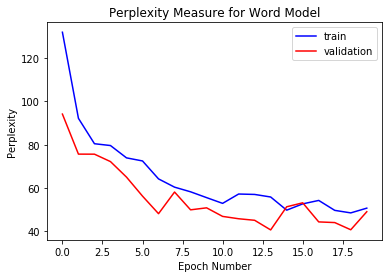

In [38]:
plt.plot(hist.history['perplexity'], 'b')
plt.plot(hist.history['val_perplexity'], 'r')
plt.title('Perplexity Measure for Word Model')
plt.ylabel('Perplexity')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

##### Plot of Accuracy v/s Epochs for the training and validation dataset.

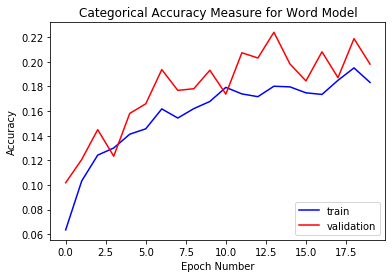

In [22]:
plt.plot(hist.history['categorical_accuracy'], 'b')
plt.plot(hist.history['val_categorical_accuracy'], 'r')
plt.title('Categorical Accuracy Measure for Word Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

##### Plot of Loss v/s Epochs for training and validation dataset.

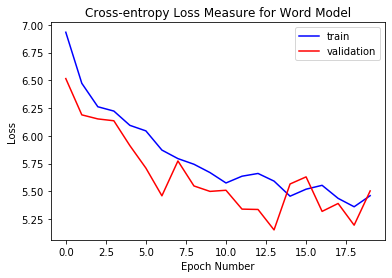

In [23]:
plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['val_loss'], 'r')
plt.title('Cross-entropy Loss Measure for Word Model')
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### Performing Word Model prediction on the test dataset for text generation.

In [40]:
iterations = 100
test_prediction_generator = KerasBatchGenerator(test_data, num_steps, 1, vocab_length,skip_step=1)
num_predict = 200
temperature = 1.0
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "
for i in range(num_predict):
    data = next(test_prediction_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, 50 - 1, :])
    predict_word = predict_word/temperature

    true_print_out += id_to_word[test_data[50 + iterations + i]] + " "
    pred_print_out += id_to_word[predict_word] + " "
print(true_print_out)
print(pred_print_out)

Actual words: floor traders by buying big blocks of stock traders say <eos> heavy selling of standard & poor 's 500-stock index futures in chicago <unk> beat stocks downward <eos> seven big board stocks ual amr bankamerica walt disney capital cities\/abc philip morris and pacific telesis group stopped trading and never resumed <eos> the <unk> has already begun <eos> the equity market was <unk> <eos> once again the specialists were not able to handle the imbalances on the floor of the new york stock exchange said christopher <unk> senior vice president at <unk> securities corp <eos> <unk> james <unk> chairman of specialists henderson brothers inc. it is easy to say the specialist is n't doing his job <eos> when the dollar is in a <unk> even central banks ca n't stop it <eos> speculators are calling for a degree of liquidity that is not there in the market <eos> many money managers and some traders had already left their offices early friday afternoon on a warm autumn day because the sto